In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [183]:
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')

# Data Explorer and Proces

In [184]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [185]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [186]:
df_train.shape

(2935849, 6)

In [187]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


we notice null value in the columns ['item_price' , 'item_cnt_day']

In [188]:
# explore the null values in the item_price
df_train[df_train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [189]:
# remove the row contain this null value
df_train = df_train[df_train['item_price']>0]
df_train.shape

(2935848, 6)

In [190]:
# explore the nule values in the item_cnt_day
df_train[df_train['item_cnt_day']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [191]:
#remove the rows contain the null values
df_train = df_train[df_train['item_cnt_day']>0]
df_train.shape

(2928492, 6)

In [192]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [193]:
# COPY THE DATA TO LET THE ORIGINAL 
df = df_train.copy()

In [194]:
# extract and copy the date from object to reall date
df['date_1'] = pd.to_datetime(df['date'], dayfirst=True)
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_1
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-02
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-03
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-06
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-15
5,10.01.2013,0,25,2564,349.00,1.0,2013-01-10
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,2015-10-10
2935845,09.10.2015,33,25,7460,299.00,1.0,2015-10-09
2935846,14.10.2015,33,25,7459,349.00,1.0,2015-10-14
2935847,22.10.2015,33,25,7440,299.00,1.0,2015-10-22


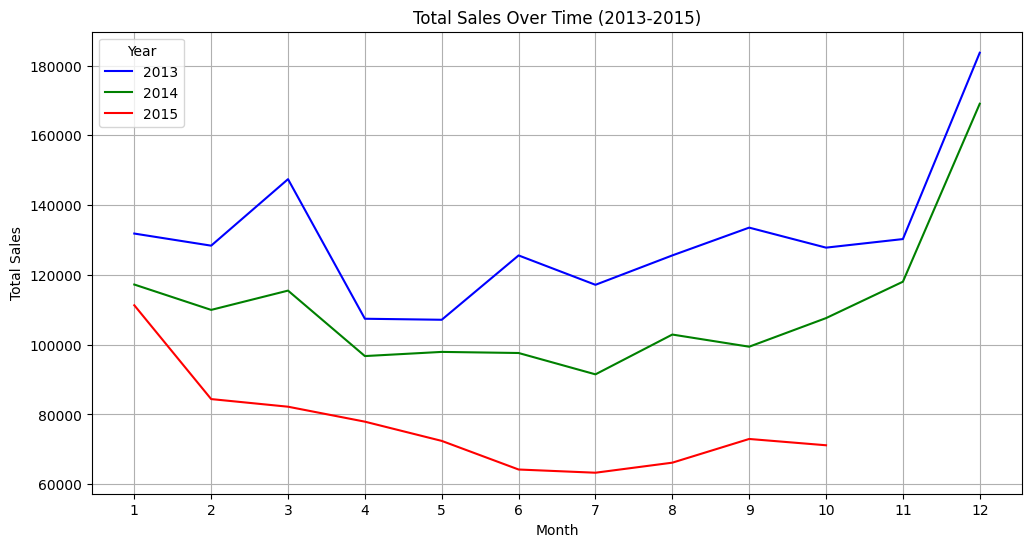

In [195]:
# extract data by deferent year than plot them
df_grouped = df.copy()
df_grouped = df_grouped.rename(columns={"item_cnt_day": "item_cnt_month"})
df_grouped['year'] = df_grouped['date_1'].dt.year
df_grouped['month'] = df_grouped['date_1'].dt.month
# Group by year and month to get the sum of item_cnt_month
df_grouped_1 = df_grouped.groupby(['year', 'month'])['item_cnt_month'].sum().reset_index()
# Extract data for each year
data_2013 = df_grouped_1[df_grouped_1['year'] == 2013]
data_2014 = df_grouped_1[df_grouped_1['year'] == 2014]
data_2015 = df_grouped_1[df_grouped_1['year'] == 2015]

# Plotting
plt.figure(figsize=(12, 6))

# Plotting data for each year
plt.plot(data_2013['month'], data_2013['item_cnt_month'], label='2013', color='b')
plt.plot(data_2014['month'], data_2014['item_cnt_month'], label='2014', color='g')
plt.plot(data_2015['month'], data_2015['item_cnt_month'], label='2015', color='r')

# Customizing the plot
plt.title('Total Sales Over Time (2013-2015)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend(title='Year')

# Set x-axis to display months from 1 to 12
plt.xticks(range(1, 13))

plt.show()

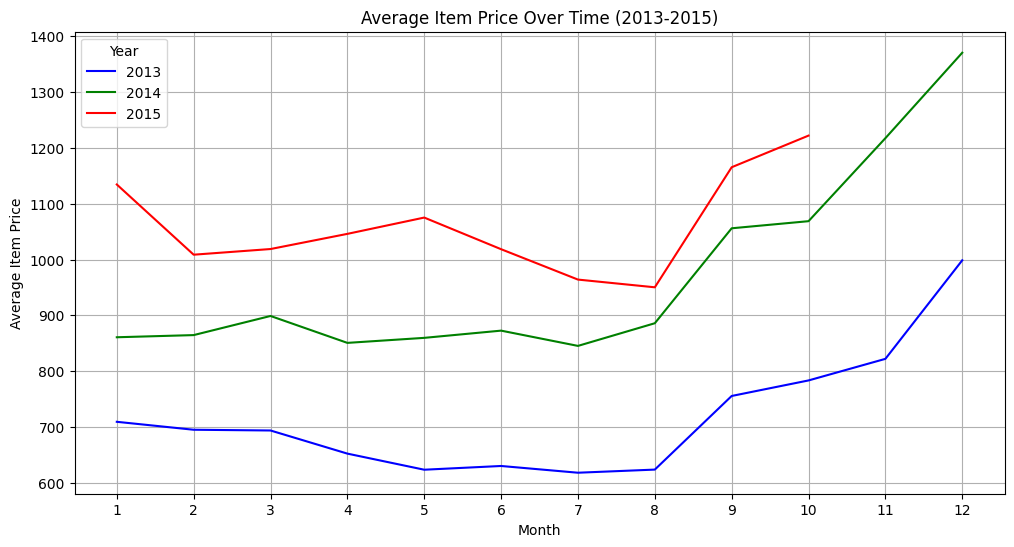

In [196]:
df['year'] = df['date_1'].dt.year
df['month'] = df['date_1'].dt.month

# Group by year and month to get the average item_price
df_grouped_price = df.groupby(['year', 'month'])['item_price'].mean().reset_index()

# Extract data for each year
price_2013 = df_grouped_price[df_grouped_price['year'] == 2013]
price_2014 = df_grouped_price[df_grouped_price['year'] == 2014]
price_2015 = df_grouped_price[df_grouped_price['year'] == 2015]

# Plotting
plt.figure(figsize=(12, 6))

# Plotting data for each year
plt.plot(price_2013['month'], price_2013['item_price'], label='2013', color='b')
plt.plot(price_2014['month'], price_2014['item_price'], label='2014', color='g')
plt.plot(price_2015['month'], price_2015['item_price'], label='2015', color='r')

# Customizing the plot
plt.title('Average Item Price Over Time (2013-2015)')
plt.xlabel('Month')
plt.ylabel('Average Item Price')
plt.grid(True)
plt.legend(title='Year')

# Set x-axis to display months from 1 to 12
plt.xticks(range(1, 13))

plt.show()


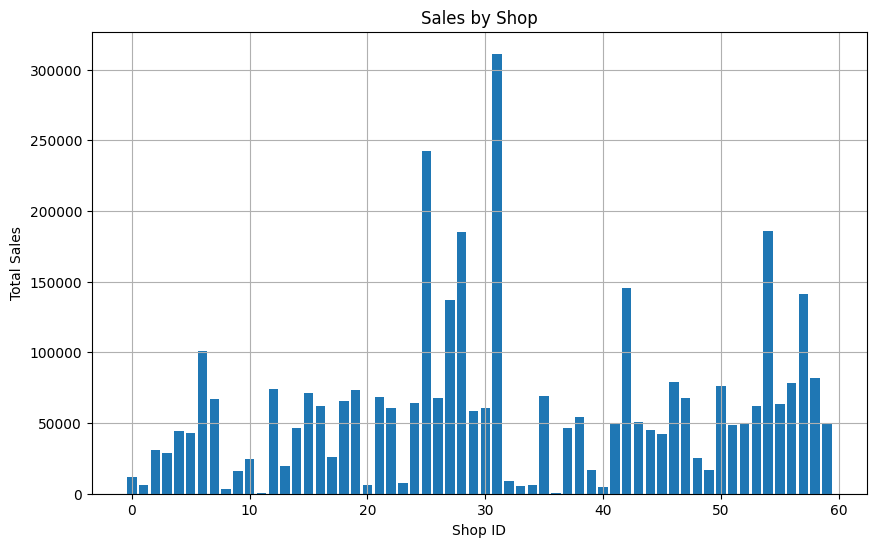

In [197]:
# Sales by Shop
df_grouped_shop = df.groupby('shop_id').agg({'item_cnt_day': 'sum'}).reset_index()
plt.figure(figsize=(10, 6))
plt.bar(df_grouped_shop['shop_id'], df_grouped_shop['item_cnt_day'])
plt.title('Sales by Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


In [198]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,day_of_week
0,2013-01-02,0,59,22154,999.00,1.0,1,2013,2
1,2013-01-03,0,25,2552,899.00,1.0,1,2013,3
3,2013-01-06,0,25,2554,1709.05,1.0,1,2013,6
4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,1
5,2013-01-10,0,25,2564,349.00,1.0,1,2013,3


In [199]:
monthly_sales = df_train.groupby(['date_block_num','shop_id','item_id']).agg(
    {
        "item_cnt_day":'sum',
        "item_price":'mean'
    }
).reset_index()
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
monthly_sales

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5
...,...,...,...,...,...
1608221,33,59,22087,6.0,119.0
1608222,33,59,22088,2.0,119.0
1608223,33,59,22091,1.0,179.0
1608224,33,59,22100,1.0,629.0


In [200]:
# Add lag features
def add_lag_feature(df, lags, col):
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df.groupby(['shop_id', 'item_id'])[col].shift(lag)
    return df
monthly_df = add_lag_feature(monthly_sales, [1,2,3], 'item_cnt_month')
monthly_df.fillna(0, inplace=True)
monthly_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,221.0,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,0.0,0.0


### Analyze the relationships between the current month's item count (item_cnt_month) and the lag features

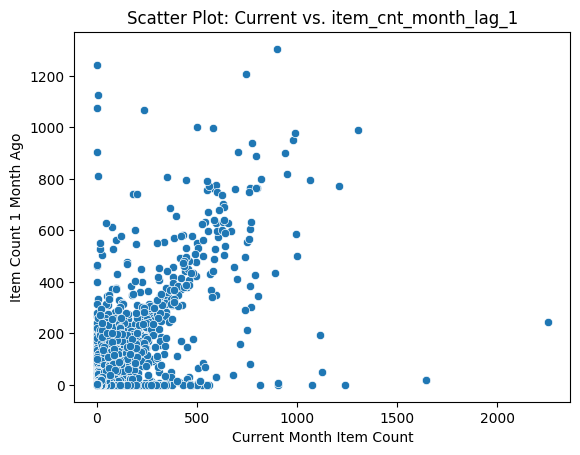

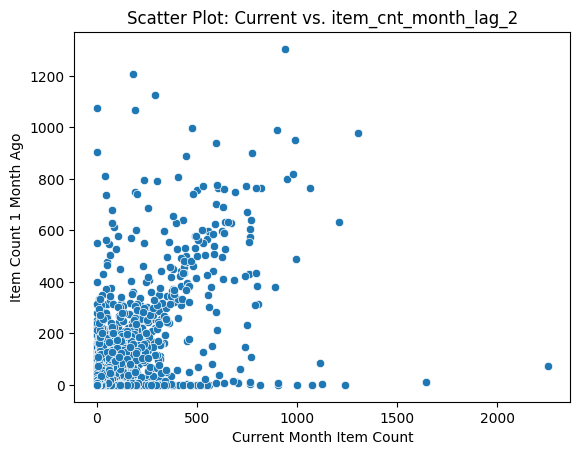

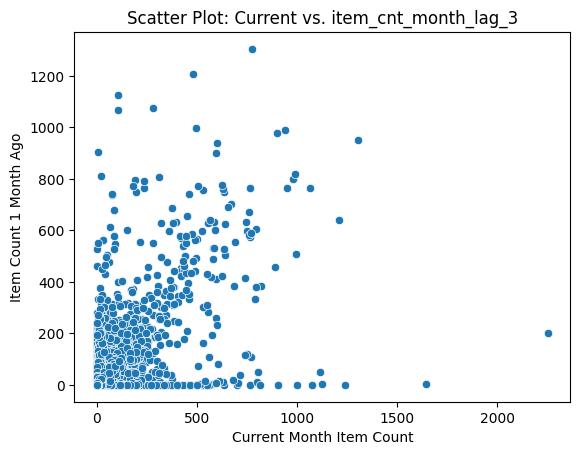

In [201]:
lag_number = ['item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3']
for item_lag in lag_number:
    # Scatter plot (one lag feature for illustration)
    sns.scatterplot(x="item_cnt_month", y=item_lag, data=monthly_df)
    plt.title(f"Scatter Plot: Current vs. {item_lag}")
    plt.xlabel("Current Month Item Count")
    plt.ylabel("Item Count 1 Month Ago")
    plt.show()

Correlation Matrix:


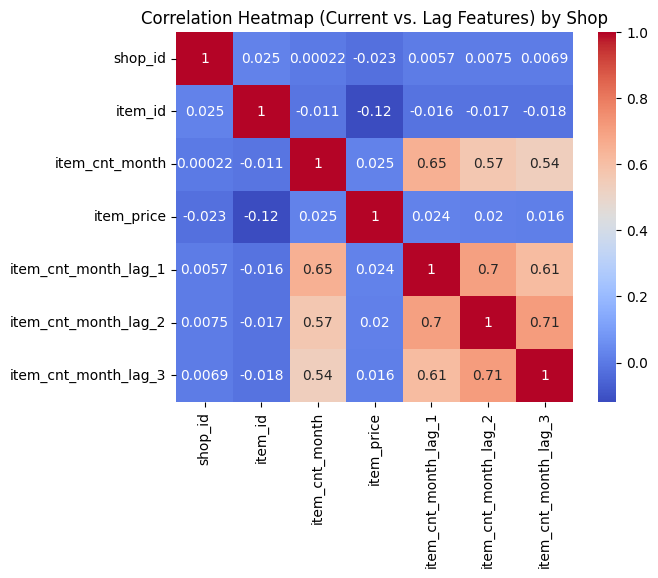

In [202]:
# Correlation analysis (all lag features)
correlations = monthly_df.iloc[:,1:].corr()
print("Correlation Matrix:")
correlations
sns.heatmap(correlations, annot=True, cmap='coolwarm')  # Assuming you have seaborn installed
plt.title("Correlation Heatmap (Current vs. Lag Features) by Shop")
plt.show()

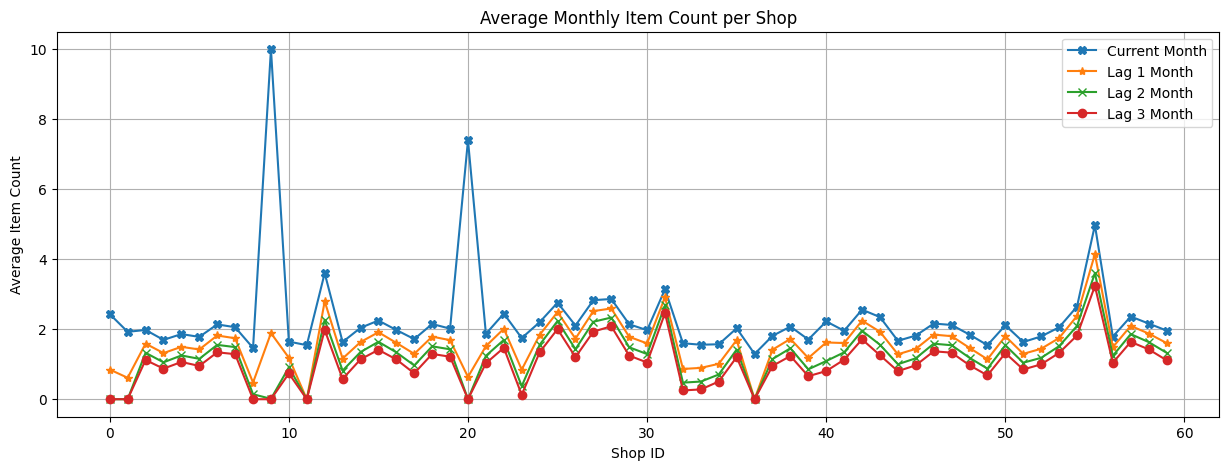

In [203]:
# Define labels for each line
labels = ['Current Month', 'Lag 1 Month', 'Lag 2 Month', 'Lag 3 Month']

#the plot
plt.figure(figsize=(15, 5))

# Plot each line with its corresponding label
monthly_df.groupby('shop_id')['item_cnt_month'].mean().plot(marker='X', label=labels[0])
monthly_df.groupby('shop_id')['item_cnt_month_lag_1'].mean().plot(marker='*', label=labels[1])
monthly_df.groupby('shop_id')['item_cnt_month_lag_2'].mean().plot(marker='x', label=labels[2])
monthly_df.groupby('shop_id')['item_cnt_month_lag_3'].mean().plot(marker='o', label=labels[3])

# Add labels and title
plt.title("Average Monthly Item Count per Shop")
plt.xlabel("Shop ID")
plt.ylabel("Average Item Count")
# Rotate shop ID labels
#plt.xticks(rotation=45)
plt.grid(True)

# Add legend
plt.legend() 

plt.show()


In [204]:
monthly_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,221.0,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,0.0,0.0


In [218]:
# # Merge with test data
# test_data = df_test.copy()
# test_data['date_block_num'] = 34
# test_data = test_data.merge(monthly_df, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
# test_data.head()

In [206]:
# Add rolling window features
monthly_df['rolling_mean_3'] = monthly_df.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3).mean())
monthly_df['rolling_std_3'] = monthly_df.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3).std())
monthly_df.fillna(0, inplace=True)
monthly_df.head()


,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,rolling_mean_3,rolling_std_3
0,0,0,32,6.0,221.0,0.0,0.0,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,0.0,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,0.0,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,0.0,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,0.0,0.0,0.0,0.0


# Machine learning

In [207]:
# Train-validation split
X_train = monthly_df[monthly_df['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y_train = monthly_df[monthly_df['date_block_num'] < 33]['item_cnt_month']
X_valid = monthly_df[monthly_df['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_valid = monthly_df[monthly_df['date_block_num'] == 33]['item_cnt_month']


In [208]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

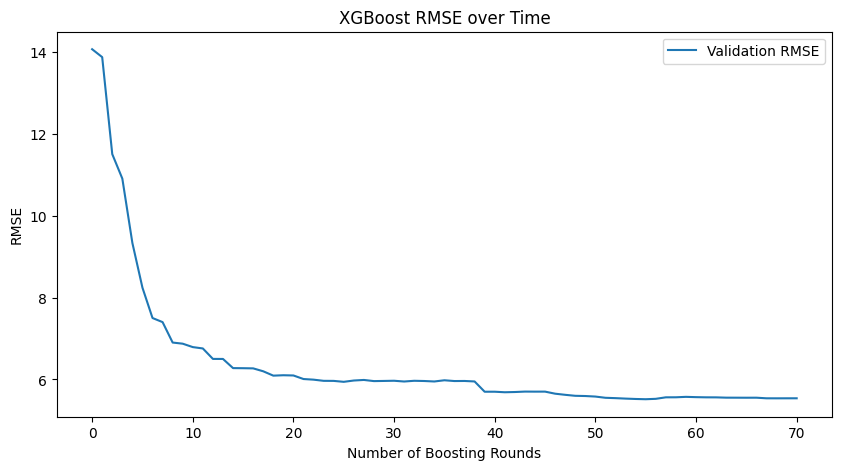

In [209]:
# Define parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.4,
    'max_depth': 7,
    'min_child_weight': 1,
    'gamma': 0.1,
    'colsample_bytree': 0.4
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dvalid, 'eval')], early_stopping_rounds=15, verbose_eval=False)

# Train the model
evals_result = {}
model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dvalid, 'eval')], 
                  early_stopping_rounds=15, evals_result=evals_result, verbose_eval=False)

# Extract the RMSE from the evaluation results
epochs = len(evals_result['eval']['rmse'])
x_axis = range(0, epochs)
rmse = evals_result['eval']['rmse']

# Plot the RMSE over the epochs
plt.figure(figsize=(10, 5))
plt.plot(x_axis, rmse, label='Validation RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Time')
plt.legend()
plt.show()

In [210]:
# Evaluate the model on the validation set
y_pred = model.predict(dvalid)
rmse = root_mean_squared_error(y_valid, y_pred)
print(f'Validation RMSE: {rmse}')

Validation RMSE: 5.540022371577104


In [213]:
test_data

,ID,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,5,5037,34,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,34,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,34,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,34,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,34,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,0.0,0.0,0.0,0.0,0.0
214196,214196,45,16188,34,0.0,0.0,0.0,0.0,0.0
214197,214197,45,15757,34,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,34,0.0,0.0,0.0,0.0,0.0


In [215]:
# Merge with test data
test_data = df_test.copy()
test_data['date_block_num'] = 34
test_data = test_data.merge(monthly_df, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
test_data.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,rolling_mean_3,rolling_std_3
0,0,5,5037,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [222]:
# Prepare the test dataset for prediction
X_test = test_data[['date_block_num','shop_id','item_id','item_price','item_cnt_month_lag_1',
                    'item_cnt_month_lag_2','item_cnt_month_lag_3','rolling_mean_3','rolling_std_3']]
dtest = xgb.DMatrix(X_test)

# Make predictions
test_data['item_cnt_month'] = model.predict(dtest).clip(0, 20).round()

In [225]:
test_data.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,rolling_mean_3,rolling_std_3
0,0,5,5037,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
# Aggregate sales by date_block_num and item_id
historical_sales = monthly_sales.groupby(['date_block_num', 'item_id'])['item_cnt_month'].sum().reset_index()

# Define items to plot
items_to_plot = historical_sales['item_id'].unique()[:5]  # Choose a subset of items to plot for clarity

# Filter data for these items
historical_sales = historical_sales[historical_sales['item_id'].isin(items_to_plot)]

In [229]:
# Aggregate predictions by date_block_num and item_id
predicted_sales = test_data.groupby(['date_block_num', 'item_id'])['item_cnt_month'].sum().reset_index()

# Filter predicted sales for the items to plot
predicted_sales = predicted_sales[predicted_sales['item_id'].isin(items_to_plot)]

# Combine historical and predicted sales
combined_sales = pd.concat([historical_sales, predicted_sales], ignore_index=True)

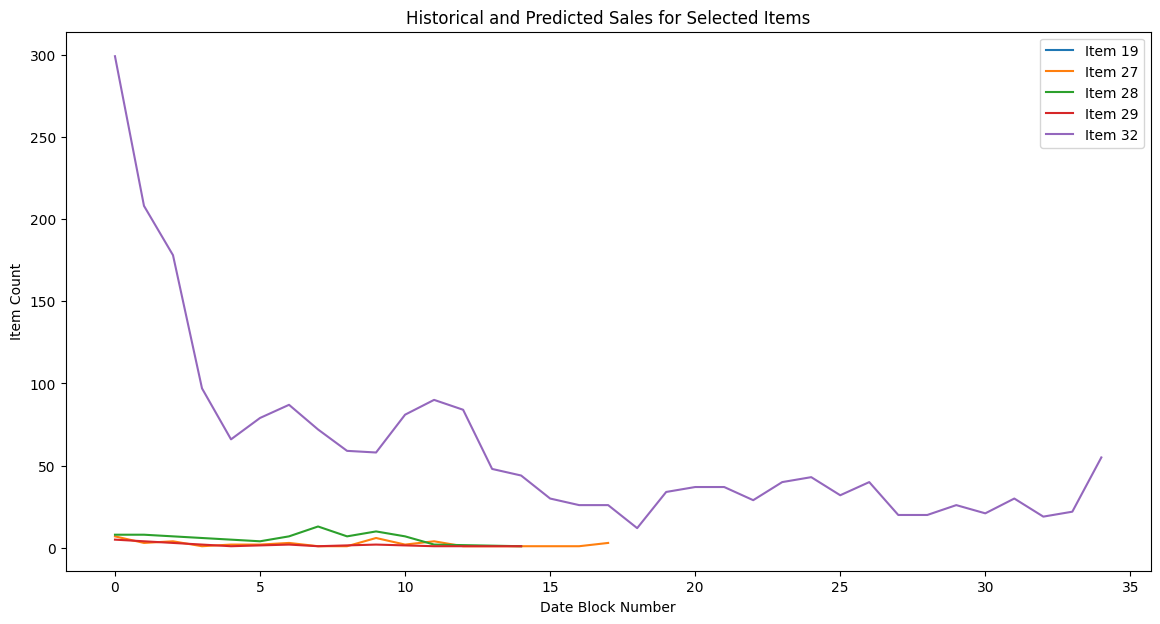

In [231]:
# Plot historical and predicted sales
plt.figure(figsize=(14, 7))

for item in items_to_plot:
    item_sales = combined_sales[combined_sales['item_id'] == item]
    plt.plot(item_sales['date_block_num'], item_sales['item_cnt_month'], label=f'Item {item}')

# Adding plot details
plt.xlabel('Date Block Number')
plt.ylabel('Item Count')
plt.title('Historical and Predicted Sales for Selected Items')
plt.legend()
plt.show()


In [234]:
# Prepare the test data for prediction
test_data = monthly_sales[monthly_sales['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)

# Function to predict sales for the next month
def predict_next_month(test_data, current_month, model):
    test_data['date_block_num'] = current_month
    dtest = xgb.DMatrix(test_data)
    test_data['item_cnt_month'] = model.predict(dtest).clip(0, 20)
    return test_data

# Initialize a DataFrame to store the predictions
predictions = pd.DataFrame()

# Predict for date_block_num 34 to 39
for month in range(34, 40):
    test_data = predict_next_month(test_data, month, model)
    predictions = pd.concat([predictions, test_data[['date_block_num', 'item_id', 'item_cnt_month']]], ignore_index=True)

# Aggregate predictions by date_block_num and item_id
predicted_sales = predictions.groupby(['date_block_num', 'item_id'])['item_cnt_month'].sum().reset_index()

# Filter predicted sales for the items to plot
predicted_sales = predicted_sales[predicted_sales['item_id'].isin(items_to_plot)]

# Combine historical and predicted sales
combined_sales = pd.concat([historical_sales, predicted_sales], ignore_index=True)


ValueError: feature_names mismatch: ['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'rolling_mean_3', 'rolling_std_3'] ['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'rolling_mean_3', 'rolling_std_3', 'item_cnt_month']
training data did not have the following fields: item_cnt_month

In [233]:
X_train

,date_block_num,shop_id,item_id,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,rolling_mean_3,rolling_std_3
0,0,0,32,221.0,0.0,0.0,0.0,0.000000,0.000000
1,0,0,33,347.0,0.0,0.0,0.0,0.000000,0.000000
2,0,0,35,247.0,0.0,0.0,0.0,0.000000,0.000000
3,0,0,43,221.0,0.0,0.0,0.0,0.000000,0.000000
4,0,0,51,128.5,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1576700,32,59,22087,119.0,2.0,5.0,1.0,3.333333,1.527525
1576701,32,59,22088,119.0,7.0,7.0,4.0,5.000000,3.464102
1576702,32,59,22091,179.0,1.0,1.0,10.0,1.666667,1.154701
1576703,32,59,22100,629.0,0.0,0.0,0.0,0.000000,0.000000


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session